# This notebook contains everything needed to make all plots for the QPS paper.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# External imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, compiler, circuit, compiler
import math
import time
import sys
import matplotlib.pyplot as plt
import matplotlib

#sys.path.append('./data/')
#sys.path.append('./plots/')

# Local imports
import QuantumPartonShower as qpso # old algo
import QuantumPartonShower_ReM as qpsc # improved algo
import plotting as pl
from PaperPlots import MakeObservables as mo

## Define variables to be used throughout the notebook

In [3]:
eps= 0.001
g_1= 2
g_2= 1
nI= 1
iP= ['100'] # one 1-fermion

## Gate counting

In [ ]:
# Note: counting the gates in QuantumCircuits with c_if's does not work, as all gates with classical conditioning
# are counting when in an actual implementation, just one of the gates is selected and applied.

# There is a special file for doing this though, where gates with mutually exclusive classical controls are removed,
# such that the correct number (1) of gates are added to the total

## Define functions that compute gate counts (mid-circuit measurements)

In [11]:
def grayList(L):
    if L == 1:
        return np.ones(1)
    else:
        return np.concatenate((grayList(L-1), np.ones(1), 1 + grayList(L-1)), 0)


def gate_counter_TLCry(L, k):
    glk= grayList(L)[k-1]
    return 14 + 12*(2*glk - 1)*(L - 2) + 2*(glk - 1)
    

def gate_counter(n_i, N):
    count_uCount= 0
    count_Ue= 0
    count_Uh= 0
    count_Up= 0
    
    for m in range(0, N):
        # Step-dependent params
        L= int(math.ceil(math.log2(n_i + m + 1)))
        nf= n_i + m - 1 + int(m % 2 == 0)
        
        # Ucount
        count_uCount+= (13*L)*(n_i + m)

        # Ue
        count_Ue+= (12*L - 10) * (nf + 1)

        # Uh
        count_Uh+= 12*L - 11
        for k in range(1, n_i + m + 1):
            lk= int(math.ceil(math.log2(k + 1)))
            
            if k <= n_i:
                nf_lk= k
            else:
                nf_lk= k - int((k-n_i) % 2 != 0)

            # with reduced registers
            #count_Uh+= 13*lk + nf_lk*(120 + 12*lk + 3*gate_counter_TLCry(L, k))
            # with full L registers
            count_Uh+= 13*L + (nf_lk+1)*(120 + 12*L + 3*gate_counter_TLCry(L, k))

        count_Uh= int(count_Uh)

        # Up
        count_Up+= 2
        
    return count_uCount, count_Ue, count_Uh, count_Up

### Count gates costs of the original circuits, using QuantumCircuits

In [ ]:
# Note, these are already computed, and stored in 'cx_naive.py'. Just load them in the cell below. (Or recompute them here.)

Nmax= 12

cx_naive= np.zeros(Nmax-1)
for n in range(1, Nmax):
    qps1= qps.QuantumPartonShower(n, 1)
    qc, qubits= qps1.createCircuit(eps, g_1, g_2, 1, iP)

    print('Qubits: ' + str(qc.num_qubits))
    print('Clbits: ' + str(qc.num_clbits))
    print('Gates: ' + str(qc.count_ops()))
    
    # Not necessary, but can double check using:
    #qcT= compiler.transpile(qc, basis_gates=['u1', 'u2', 'u3', 'h', 'z', 'y', 'x', 'ry', 'rz', 'rx', 'cx'], optimization_level= 1)
    #print('Transpiled Gates: ' + str(qcT.count_ops()))
    #cx_naive[n]= qcT.count_ops()['cx']
    
    ops= qc.count_ops()
    cx_naive[n-1]= int(ops['cx'] + 6*ops['ccx'] + ops['ch'] + 2*ops['cry']) 
    print('CX Gates: ' + str(cx_naive[n-1]))

save= False
if save:
    np.save('cx_naive', cx_naive)

### Plot and save

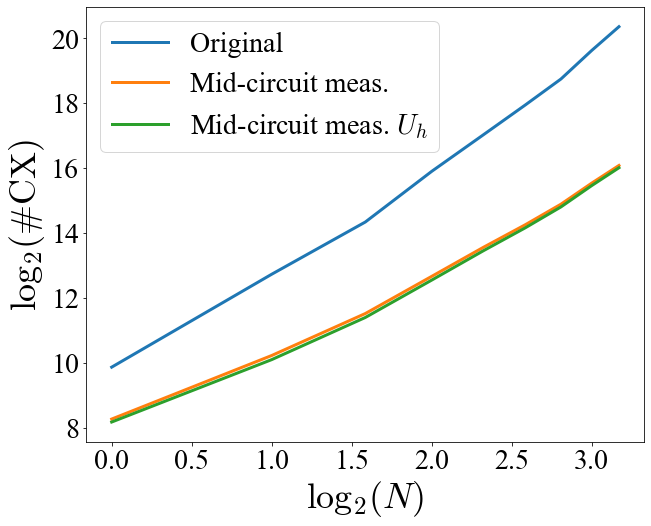

In [29]:
# Total log gates counts:

N= 17 # Compute 1..N steps, < Nmax from previous cell
n= 9 # Plot 1..n steps

Narray= np.arange(1, N)
uCount= np.zeros(N-1)
Ue= np.zeros(N-1)
Uh= np.zeros(N-1)
Up= np.zeros(N-1)

for j in range(1, N):
    uCount[j-1], Ue[j-1], Uh[j-1], Up[j-1]= gate_counter(1, j)

total= uCount + Ue + Uh + Up

plt.figure(figsize=(10, 8))
plt.rcParams['mathtext.fontset'] = 'cm'

# Either load the original counts from cx_naive.npy, or compute them in the previous cell
load= True
if load:
    cx_naive= np.load('cx_naive.npy')

plt.plot(np.log2(Narray[:n]), np.log2(cx_naive[:n]), linewidth= 3, label='Original')
plt.plot(np.log2(Narray[:n]), np.log2(total[:n]), linewidth= 3, label='Mid-circuit meas.')
plt.plot(np.log2(Narray[:n]), np.log2(Uh[:n]), linewidth= 3, label=r'Mid-circuit meas. $U_h$')
plt.xlabel(r'$\log_2(N)$', fontname= 'times new roman', fontsize= 36)
plt.ylabel(r'$\log_2(\#\mathrm{CX})$', fontname= 'times new roman', fontsize= 36)
plt.xticks(size= 28, fontname= 'times new roman')
plt.yticks(size= 28, fontname= 'times new roman')
plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 28))

#plt.savefig('gate_count_prototype.pdf')
plt.show()

## Qubit counting

### Define functions that compute qubits counts

In [8]:
def qubit_count_new(N, ni):
    return int(3*(N+ni) + 4*math.ceil(math.log2(N+ni)) + 2)

def qubit_count_original(N, ni):
    return int(3*(N+ni) + 7*math.ceil(math.log2(N+ni)) + 6 + np.sum(np.ceil(np.log2(np.arange(0, N) + ni + 1))))

def qubit_count_original_old(N, ni):
    '''
    Deprecated (not quite correct).
    '''
    return int(3*(N+ni) + (N+7)*math.ceil(math.log2(N+ni)) + 6)

### Plot and save

N: 1,    orig: 20,     new: 12
N: 2,    orig: 32,     new: 19
N: 3,    orig: 37,     new: 22
N: 4,    orig: 50,     new: 29
N: 5,    orig: 56,     new: 32
N: 6,    orig: 62,     new: 35
N: 7,    orig: 68,     new: 38
N: 8,    orig: 82,     new: 45
N: 9,    orig: 89,     new: 48
N: 10,    orig: 96,     new: 51
N: 11,    orig: 103,     new: 54
N: 12,    orig: 110,     new: 57
N: 13,    orig: 117,     new: 60
N: 14,    orig: 124,     new: 63
N: 15,    orig: 131,     new: 66
N: 16,    orig: 146,     new: 73
N: 17,    orig: 154,     new: 76


(array([  0.,  20.,  40.,  60.,  80., 100., 120., 140., 160., 180.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

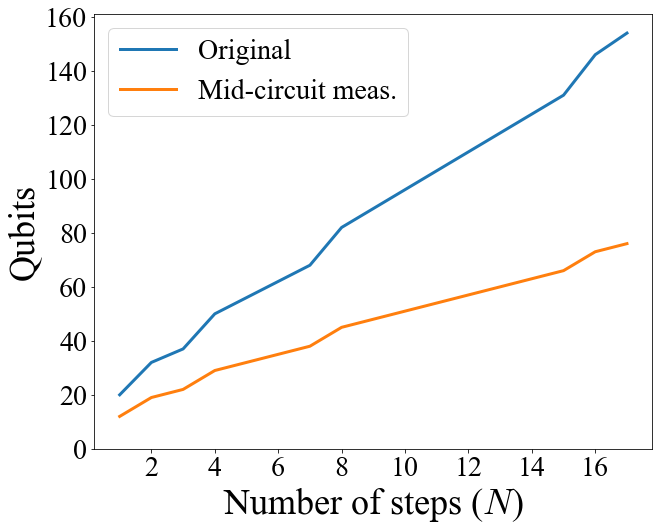

In [28]:
Nmax= 17

orig_qubits= np.arange(Nmax)
new_qubits= np.arange(Nmax)

for N in range(1, Nmax+1):
    orig_qubits[N-1]= qubit_count_original(N, nI)
    new_qubits[N-1]= qubit_count_new(N, nI)

    print('N: %d,    ' %(N) + 'orig: ' + str(orig_qubits[N-1]) + ',     new: ' + str(new_qubits[N-1]))
    

plt.figure(figsize=(10, 8))
plt.rcParams['mathtext.fontset'] = 'cm'

plt.plot(np.arange(1, Nmax+1, 1), orig_qubits, linewidth= 3, label='Original')
plt.plot(np.arange(1, Nmax+1, 1), new_qubits, linewidth= 3, label='Mid-circuit meas.')
plt.legend(prop=matplotlib.font_manager.FontProperties(family='times new roman', size= 28))

plt.ylim(bottom=0)
plt.xlabel('Number of steps ($N$)', fontname= 'times new roman', fontsize= 36)
plt.ylabel('Qubits', fontname= 'times new roman', fontsize= 36)
plt.xticks(size= 28, fontname= 'times new roman')
plt.yticks(size= 28, fontname= 'times new roman')

#plt.savefig('qubits_old_new.pdf')
plt.show()

## Oberservables Data -- number of emissions (E) and hardest emission (θmax)

### Define statistical parameters for plotting

In [24]:
sim_shots= int(1e5)
mcmc_shots= int(1e6)
n_analytical= int(1e5)

n1_i= 1 # initial f1
n2_i= 0 # initial f2

### Perform classical MCMC simulation for (E)

In [16]:
# Note: this data is already saved in the data directory. Skip this cell to use the saved data, or run this cell
# to recompute the classical MCMC.

import classical as cl

for N in range(1, 6):
    
    emits= np.zeros(N+1)
    for j in range(mcmc_shots):
        n_emits, n_a, n_b, n_phi= cl.MCMC(eps, g_1, g_2, n1_i, n2_i, N, verbose=False)
        emits[n_emits]+= 1

    emits/= mcmc_shots
    np.save('mcmc_%dstep_na=%d_nb=%d_shots=%s.npy' %(N, n1_i, n2_i, '{:.0e}'.format(mcmc_shots)), emits)

print('Done.')

Done.


### Compute analytical θmax for g12= 0.

In [10]:
# Note: this data is already saved in the data directory. Skip this cell to use the saved data, or run this cell
# to recompute the analytical θmax function.

import classical as cl

for N in range(1, 6):    

    if n1_i == 1:
        gL= g_1
    if n2_i == 1:
        gL= g_2

    lnxList = [math.log(eps**((i+0.5) / n_analytical)) for i in range(0, n_analytical)]
    yLList = [cl.dsigma_d_t_max(lnx, math.log(eps)/N, gL, normalized=False) for lnx in lnxList]

    np.savez('thetamax_analytical_N=%d_points=%s' %(N, '{:.0e}'.format(n_analytical)), lnxList, yLList)

print('Done.')

Done.


### Get simulation counts for the original QPS

In [21]:
# Note: this data is already saved in the data directory. Skip this cell to use the saved data, or run this cell
# for each N you want in the plot to get new simulation data.

import QuantumPartonShower as qpso

N= 2

print('Beginning...')
qps1o= qpso.QuantumPartonShower(N, 1) # newest remeasurement
qc1o, qubits1o= qps1o.createCircuit(eps, g_1, g_2, 1, iP)
print('g= 1 circuit constructed.')

qps0o= qpso.QuantumPartonShower(N, 1) # newest remeasurement
qc0o, qubits0o= qps0o.createCircuit(eps, g_1, g_2, 0, iP)
print('g= 0 circuit constructed.\n')

print('Qubits: ' + str(qc0o.num_qubits))
print('Clbits: ' + str(qc0o.num_clbits))
print('Gates: ' + str(qc0o.count_ops()))

t1= time.time()
counts= qps1o.simulate('mps', shots=sim_shots, position=False)
print('g= 1 simulation finished.')
t2= time.time()
counts2= qps0o.simulate('mps', shots=sim_shots, position=False)
t3= time.time()
print('g= 0 simulation finished.\n')

print('\nN= %d' %(N))
print('Simulation g12= 1 time: %.6f' %(t2 - t1))
print('Simulation g12= 0 time: %.6f\n\n' %(t3 - t2))

#np.save('counts_OLD_%dstep_g12=1_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), counts)
#np.save('counts_OLD_%dstep_g12=0_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), counts2)

Beginning...
g= 1 circuit constructed.
g= 0 circuit constructed.

Qubits: 33
Clbits: 0
Gates: OrderedDict([('ccx', 1105), ('x', 973), ('cry', 75), ('cx', 20), ('ch', 3)])
g= 1 simulation finished.
g= 0 simulation finished.


N= 2
Simulation g12= 1: 1.468312
Simulation g12= 0: 1.333578




In [ ]:
np.save('counts_OLD_%dstep_g12=1_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), counts)
np.save('counts_OLD_%dstep_g12=0_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), counts2)

### Get simulation counts for QPS with mid-circuit measurements

In [15]:
# Note: this data is already saved in the data directory. Skip this cell to use the saved data, or run this cell
# for each N you want in the plot to get new simulation data.

import QuantumPartonShower_ReM as qpsc

N= 2

print('Beginning...')
qps1= qpsc.QuantumPartonShower(N, 1)
qc1, qubits1= qps1.createCircuit(eps, g_1, g_2, 1, iP)
print('g= 1 circuit constructed.')

qps0= qpsc.QuantumPartonShower(N, 1)
qc0, qubits0= qps0.createCircuit(eps, g_1, g_2, 0, iP)
print('g= 0 circuit constructed.\n')

print('Qubits: ' + str(qc0.num_qubits))
print('Clbits: ' + str(qc0.num_clbits))
print('Gates: ' + str(qc0.count_ops()))

t1= time.time()
counts= qps1.simulate('mps', shots=sim_shots, position=False)
print('\ng= 1 simulation finished.')
t2= time.time()
counts2= qps0.simulate('mps', shots=sim_shots, position=False)
print('g= 0 simulation finished.')
t3= time.time()

print('\nN= %d' %(N))
print('Simulation g12= 1 time: %.6f' %(t2 - t1))
print('Simulation g12= 0 time: %.6f\n\n' %(t3 - t2))

#np.save('counts_%dstep_g12=1_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), counts)
#np.save('counts_%dstep_g12=0_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), counts2)

Beginning...
g= 1 circuit constructed.
g= 0 circuit constructed.

Qubits: 19
Clbits: 21
Gates: OrderedDict([('ccx', 278), ('x', 259), ('cry', 46), ('cx', 40), ('measure', 4), ('reset', 4), ('ch', 4)])

g= 1 simulation finished.
g= 0 simulation finished.

Simulation g12= 1 time: 0.403765
Simulation g12= 0 time: 0.356226




In [11]:
np.save('counts_%dstep_g12=1_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), counts)
np.save('counts_%dstep_g12=0_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), counts2)

### Plot E

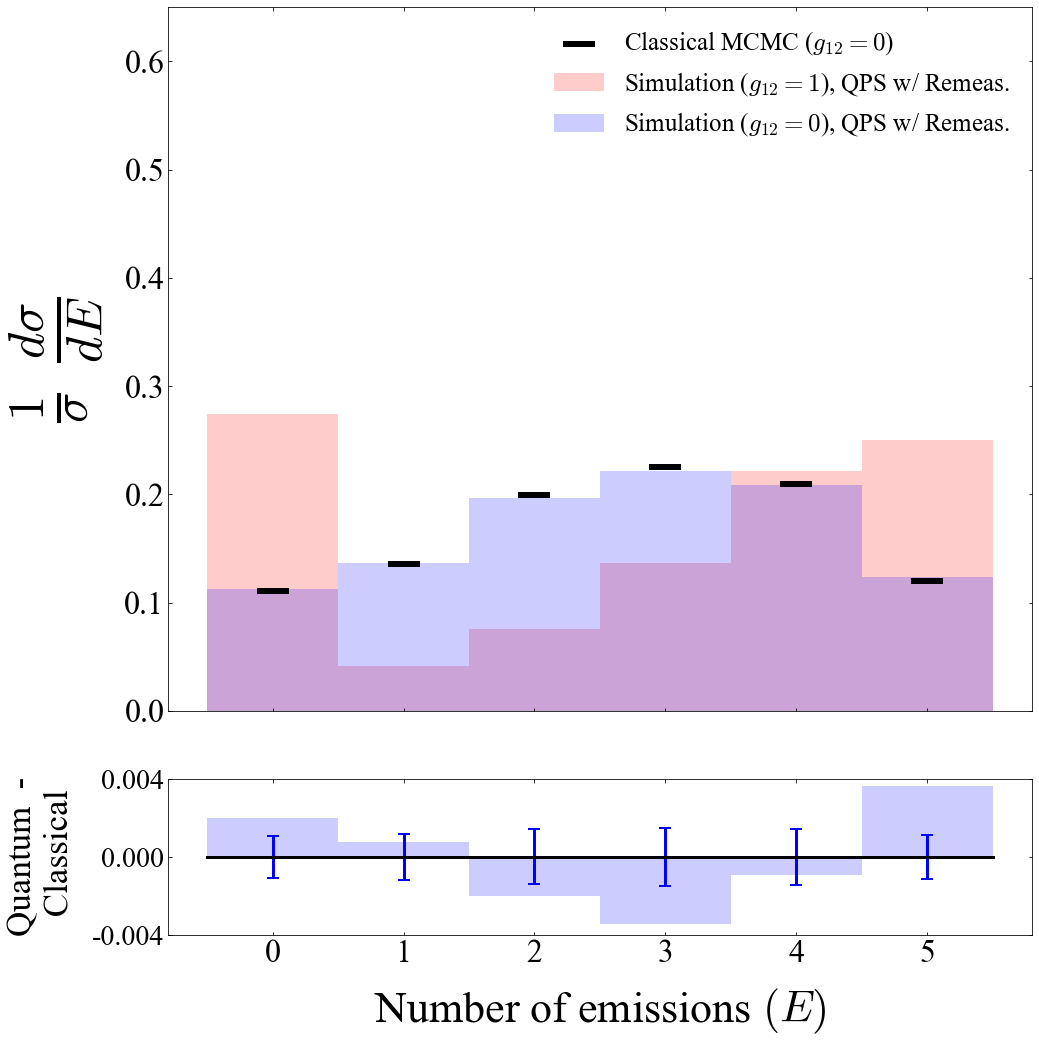

In [46]:
import plotting as pl

# Plots for each N are made separately, just change the value of N below.
# Ensure that the correct data is saved with the correct name; otherwise this cell might not work.
N= 5

# Load data
counts= np.load('counts_%dstep_g12=1_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
counts2= np.load('counts_%dstep_g12=0_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
mcmc= np.load('mcmc_%dstep_na=%d_nb=%d_shots=%s.npy' %(N, n1_i, n2_i, '{:.0e}'.format(mcmc_shots)))

if N < 5:
    countsOld= np.load('counts_OLD_%dstep_g12=1_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
    countsOld2= np.load('counts_OLD_%dstep_g12=0_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
    countsTup= countsOld, countsOld2
else:
    countsTup=None

# Make plot: set save=True to save the result as a pdf.
pl.master_plot_phisplit_emissions(g_1, g_2, N, 1, sim_shots, counts, counts2, mcmc=mcmc, save=True, old_alg=countsTup)

### Plot θmax

0 50000


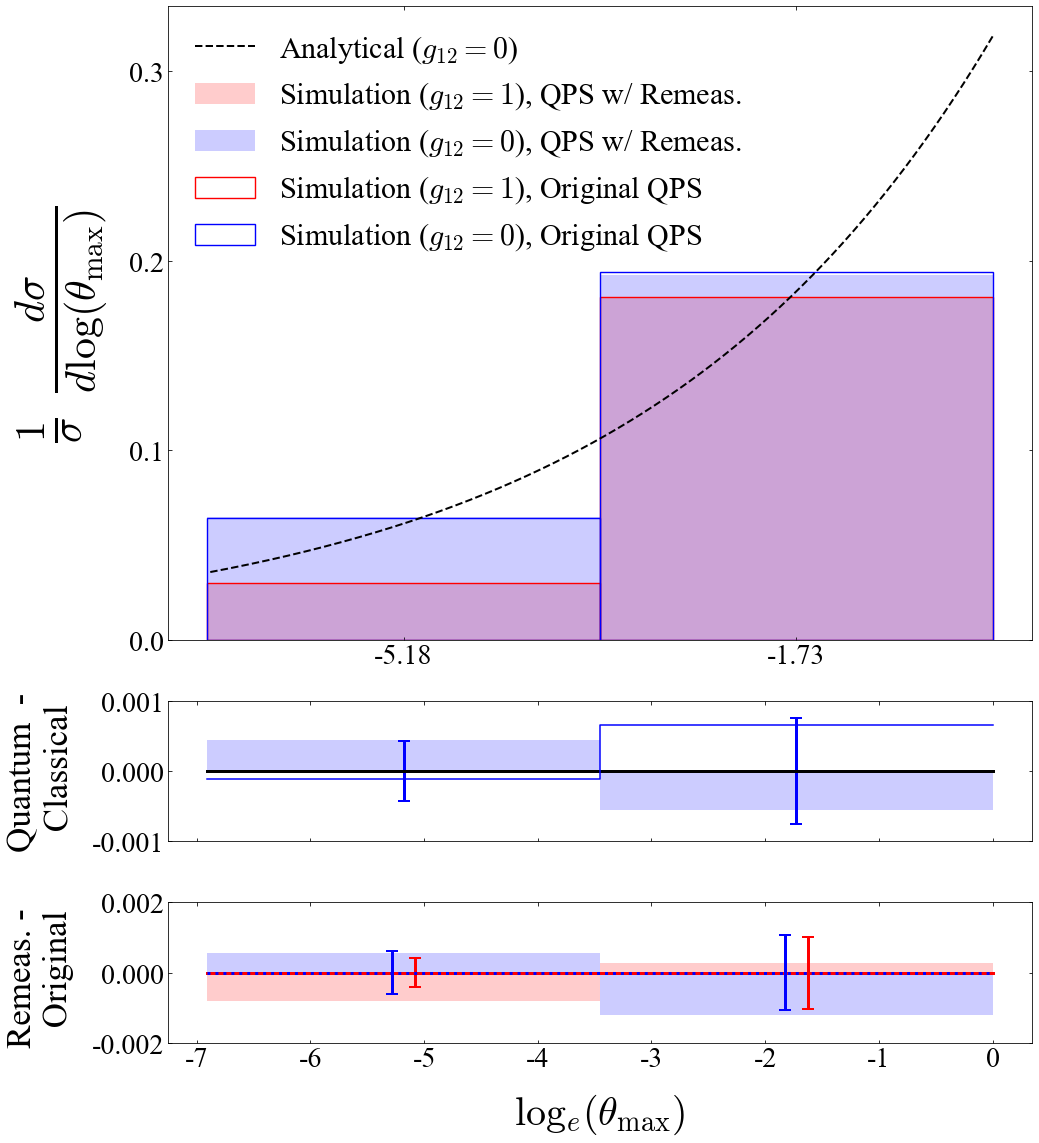

In [50]:
import plotting as pl

# Plots for each N are made separately, just change the value of N below.
# Ensure that the correct data is saved with the correct name; otherwise this cell might not work.
N= 2

# Load data
counts= np.load('counts_%dstep_g12=1_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
counts2= np.load('counts_%dstep_g12=0_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()

if N < 5:
    countsOld= np.load('counts_OLD_%dstep_g12=1_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
    countsOld2= np.load('counts_OLD_%dstep_g12=0_shots=%s.npy' %(N, '{:.0e}'.format(sim_shots)), allow_pickle='TRUE').item()
    countsTup= countsOld, countsOld2
else:
    countsTup=None
    
npzfile = np.load('thetamax_analytical_N=%d_points=%s.npz' %(N, '{:.0e}'.format(n_analytical)))
ax= npzfile['arr_0']
ay= npzfile['arr_1']

# Make plot: set save=True to save the result as a pdf.
pl.master_plot_phisplit_thetamax(eps, g_1, g_2, N, 1, sim_shots, counts, counts2, analytical= (ax, ay), save=True, normalized=True, old_alg=countsTup)